In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 15.3 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from numpy import linalg
import seaborn as sns

In [13]:
assets=['MSFT','TSLA']
SHARES=[5,5]
START_DATE='2018-01-01'
END_DATE='2018-12-31'
T=1
N_SIMS=10**5

In [4]:
df=yf.download(assets,start=START_DATE,end=END_DATE,adjusted=True)
df.head()

[*********************100%***********************]  2 of 2 completed


Adj Close                 Close  ...       Open    Volume          
                 MSFT       TSLA       MSFT  ...       TSLA      MSFT      TSLA
Date                                         ...                               
2018-01-02  81.698814  64.106003  85.949997  ...  62.400002  22483800  21761000
2018-01-03  82.079025  63.450001  86.349998  ...  64.199997  26061400  22607500
2018-01-04  82.801445  62.924000  87.110001  ...  62.574001  21912000  49731500
2018-01-05  83.828026  63.316002  88.190002  ...  63.324001  23407100  22956000
2018-01-08  83.913559  67.281998  88.279999  ...  63.200001  22113000  49297000

[5 rows x 12 columns]

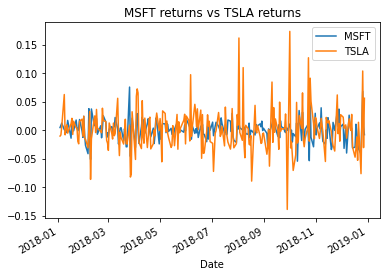

In [5]:
adj_close=df['Adj Close']
returns=adj_close.pct_change().dropna()
plot_title=f'{assets[0]} returns vs {assets[1]} returns'
returns.plot(title=plot_title)

In [7]:
covmat=returns.cov()
covmat

,MSFT,TSLA
MSFT,0.000319,0.000258
TSLA,0.000258,0.001369


In [9]:
chol=linalg.cholesky(covmat)

In [10]:
rv=np.random.normal(size=(N_SIMS,len(assets)))
correlated_rv=np.matmul(chol,rv.T).T

In [14]:
r=np.mean(returns,axis=0).values
sigma=np.std(returns,axis=0).values
S_0=adj_close.values[-1,:]
P_0=np.sum(SHARES*S_0)

In [15]:
S_T=S_0*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*correlated_rv)

In [16]:
P_T=np.sum(SHARES*S_T,axis=1)
P_diff = P_T-P_0

In [21]:
P_diff_sorted=np.sort(P_diff)
percentiles=[0.01,0.1,1.]
var=np.percentile(P_diff_sorted,percentiles)

for x,y in zip(percentiles,var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 1.59$
1-day VaR with 99.9% confidence: 1.25$
1-day VaR with 99.0% confidence: 0.84$


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


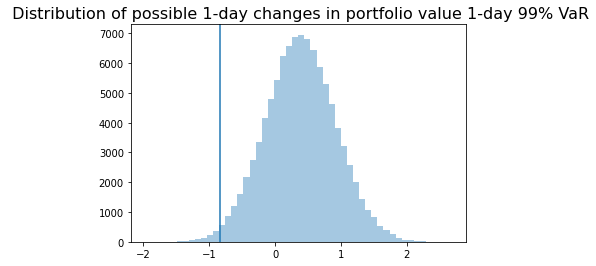

In [24]:
ax=sns.distplot(P_diff,kde=False)
ax.set_title(''' Distribution of possible 1-day changes in portfolio value 1-day 99% VaR''',fontsize=16)
ax.axvline(var[2],0,10000)